# Increasing Prediction Accuracy by using Ensembling Methods

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load required data

In [3]:
data_dir = '/content/drive/My Drive/processed_data/final_hope'

X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))


In [4]:
true_labels = np.argmax(y_test, axis=1)

### Load best models based on test-accuracy

Load best VGG-model:

In [5]:
from tensorflow.keras.models import load_model

# Load your models
model_1 = load_model('/content/drive/My Drive/processed_data/NewLayer_Hopium.h5')


Load best ResNet-model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model

tf.keras.backend.clear_session()

import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input, Flatten, Dense, GlobalAveragePooling2D, Lambda, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout


def create_saliency_network(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder: downsample the input
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder: upsample the feature map
    up1 = UpSampling2D((2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    up2 = UpSampling2D((2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)

    # Output a saliency map and replicate it across three channels
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    replicated_output = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(saliency_output)

    model = Model(inputs=inputs, outputs=replicated_output)
    return model



def create_age_model(input_shape):
    # Saliency model
    saliency_model = create_saliency_network(input_shape)

    # Base ResNet152V2 model
    base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    # Connect the output of the saliency network to the input of the ResNet152V2 base model
    resnet_output = base_model(saliency_model.output)

    # Additional Convolutional Layer for further feature refinement
    conv_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(resnet_output)
    batch_norm = BatchNormalization()(conv_layer)
    dropout_layer = Dropout(0.5)(batch_norm)

    # Flatten and dense layers for age prediction
    flat_features = Flatten()(dropout_layer)
    lri_features = Dense(2058, activation='relu',kernel_regularizer=l2(0.005))(flat_features)  # Simulating LRI
    dr_reg1 = Dropout(0.25)(lri_features)
    dense1 = Dense(1024, activation='relu',kernel_regularizer=l2(0.005))(dr_reg1)
    dr_reg2 = Dropout(0.25)(dense1)
    age_output = Dense(5, activation='softmax', name='age_output')(dr_reg2)

    model = Model(inputs=saliency_model.input, outputs=age_output)
    return model

model_2 = create_age_model(input_shape=(224, 224, 3))
model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

full_path_to_weights = '/content/drive/My Drive/processed_data/tom_weights.h5'

# Attempt to load weights
try:
    model_2.load_weights(full_path_to_weights)
    print("Weights loaded successfully.")
except ValueError as e:
    print(f"Failed to load weights: {e}")

Weights loaded successfully.


### Single model prediction accuracies

In [11]:
predictions_1 = model_1.predict(X_test)
predictions_2 = model_2.predict(X_test)

118/118 [==============================] - 52s 401ms/step


In [12]:
# Convert probabilities to final class labels
final_model1_predictions = np.argmax(predictions_1, axis=1)
final_model2_predictions = np.argmax(predictions_2, axis=1)

accuracy_model1 = accuracy_score(true_labels, final_model1_predictions)
accuracy_model2 = accuracy_score(true_labels, final_model2_predictions)

print("Model 1 Accuracy: {:.2f}%".format(accuracy_model1 * 100))
print("Model 2 Accuracy: {:.2f}%".format(accuracy_model2 * 100))

Model 1 Accuracy: 67.18%
Model 2 Accuracy: 64.49%


### Ensemble prediction by simple averaging

Interestingly, even this simple approach yields a significant improvement in overall accuracy:

In [13]:
combined_predictions = (predictions_1 + predictions_2) / 2

# Convert probabilities to final class labels
ensemble_predictions = np.argmax(combined_predictions, axis=1)

avg_ensemble_accuracy = accuracy_score(true_labels, ensemble_predictions)


print("Simple Average Ensemble Accuracy: {:.2f}%".format(avg_ensemble_accuracy * 100))


Simple Average Ensemble Accuracy: 70.03%


### Using a neural network for ensembling

This model is trained on the predictions from both models and tries to learn the relation between the model predictions and the true labels. Creating the needed data sets:

In [14]:
from sklearn.model_selection import train_test_split

# Define a more complex meta-model

combined_predictions = np.concatenate([predictions_1, predictions_2], axis=1)

# Split data for training and validation of the meta-model
X_train, X_val, y_train, y_val = train_test_split(combined_predictions, y_test, test_size=0.1, random_state=42)


Model architecture, compiling and fitting:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define neural network to serve as the meta-model
meta_model = Sequential([
    Dense(512, activation='relu', input_shape=(combined_predictions.shape[1],)),

    Dense(256, activation='relu'),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(32, activation='relu'),

    Dense(16, activation='relu'),

    Dense(5, activation='softmax')
])

# Compile the meta-model
optimizer = Adam(learning_rate=0.0001)
meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the meta-model
history = meta_model.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr, early_stopping])

# Evaluate the meta-model
evaluation_results = meta_model.evaluate(X_val, y_val)
print(f"Meta-model evaluation results - Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")


Epoch 1/100
106/106 [==============================] - 3s 6ms/step - loss: 1.3533 - accuracy: 0.4969 - val_loss: 1.1515 - val_accuracy: 0.4840 - lr: 1.0000e-04
Epoch 2/100
106/106 [==============================] - 0s 4ms/step - loss: 1.0504 - accuracy: 0.5620 - val_loss: 1.0739 - val_accuracy: 0.5399 - lr: 1.0000e-04
Epoch 3/100
106/106 [==============================] - 0s 4ms/step - loss: 0.9855 - accuracy: 0.6117 - val_loss: 1.0122 - val_accuracy: 0.6516 - lr: 1.0000e-04
Epoch 4/100
106/106 [==============================] - 0s 4ms/step - loss: 0.9126 - accuracy: 0.6959 - val_loss: 0.9467 - val_accuracy: 0.6676 - lr: 1.0000e-04
Epoch 5/100
106/106 [==============================] - 0s 4ms/step - loss: 0.8492 - accuracy: 0.7001 - val_loss: 0.8669 - val_accuracy: 0.6782 - lr: 1.0000e-04
Epoch 6/100
106/106 [==============================] - 0s 4ms/step - loss: 0.8051 - accuracy: 0.7087 - val_loss: 0.8372 - val_accuracy: 0.6862 - lr: 1.0000e-04
Epoch 7/100
106/106 [===================

### Hyperparameter optimization
Since this is a simple model, we can perform extensive automated hyperparameter optimization in a reasonable amount of time using the 'keras_tuner' library's RandomSearch. We set up the hyper model using the 'RSHyperModel' class which is taylored to our ensembling model and allows for variation in the number of layers as well as all other basic hyperparameters.

In [17]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import HyperModel, RandomSearch

class RSHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu', input_shape=self.input_shape))

        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                activation='relu'))
            model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return model

# Instantiate the hypermodel
hypermodel = RSHyperModel(input_shape=(combined_predictions.shape[1],), num_classes=5)


Here we perform the Random search and save the best model:

In [18]:
# Creating a tuner instance with the desired parameters
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_test'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start search
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 20 Complete [00h 00m 13s]
val_accuracy: 0.686170220375061

Best val_accuracy So Far: 0.7021276354789734
Total elapsed time: 00h 04m 22s


The best model achieves an accuracy of 70% on the validation set, though much more relevant is the resulting accuracy when we use this ensembling model to combine the original two models.

In [19]:
evaluation_results = best_model.evaluate(X_val, y_val)
print(f"Best model evaluation results - Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

12/12 [==============================] - 0s 2ms/step - loss: 0.8489 - accuracy: 0.7021
Best model evaluation results - Loss: 0.8488671183586121, Accuracy: 0.7021276354789734


Using the model trained above to create an ensemble of the original models slightly improves accuracy to 70.27% (compared to 67.18% for the best single model):

In [20]:
# Combine the predictions for the meta-model input
combined_test_predictions = np.concatenate([predictions_1, predictions_2], axis=1)

# Use meta-model to predict the final outputs
final_predictions = best_model.predict(combined_test_predictions)
ensemble_predicted_classes = np.argmax(final_predictions, axis=1)

118/118 [==============================] - 0s 2ms/step


In [21]:
stacker_accuracy = accuracy_score(ensemble_predicted_classes, true_labels)
print("Ensemble Classification Accuracy: {:.2f}%".format(stacker_accuracy * 100))

Ensemble Classification Accuracy: 70.27%


### Creating an ensemble through logistic model stacking
We can also combine the original model's predictions using a simpler model. In the code below we use a logistic model to get the ensemble predictions. As might be expected, this approach leads to lower classification accuracy than the much more complex neural model. Surprisingly, it also performs worse than the simple average.

In [22]:
from sklearn.linear_model import LogisticRegression

combined_predictions = np.concatenate([predictions_1, predictions_2], axis=1)

X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(
    combined_predictions, y_test, test_size=0.2, random_state=42)

y_train_stack = np.argmax(y_train_stack, axis=1)
y_val_stack = np.argmax(y_val_stack, axis=1)

stacker = LogisticRegression()
stacker.fit(X_train_stack, y_train_stack)

y_pred_stack = stacker.predict(X_val_stack)
stacker_accuracy = accuracy_score(y_val_stack, y_pred_stack)
print("Stacker Accuracy: {:.2f}%".format(stacker_accuracy * 100))


Stacker Accuracy: 68.22%


## Results for the best ensembling method (neural network)

[[413 160   5   4  10]
 [ 68 746 189   3   0]
 [  8 221 697  72   2]
 [  7  18 179 381  91]
 [  2   1  12  65 403]]


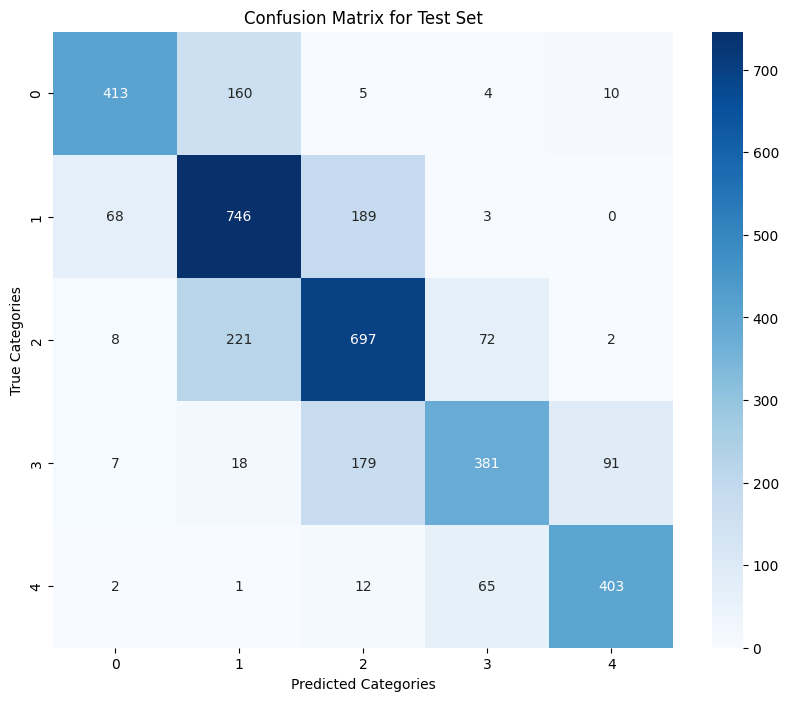

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, ensemble_predicted_classes)
print(cm)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.show()

In [24]:
# Calculate class-wise accuracy and round it to two decimal places
class_accuracies = np.round(cm.diagonal() / cm.sum(axis=1), 4)

class_accuracies

array([0.6976, 0.7416, 0.697 , 0.5636, 0.8344])

In [25]:
def one_off_accuracy(y_true, y_pred):

    # Compute the absolute difference between true and predicted classes
    abs_diff = tf.abs(y_true - y_pred)

    # Check if the prediction is exact or off by one
    correct_or_one_off = tf.cast(tf.less_equal(abs_diff, 1), tf.float32)

    # Compute the mean accuracy of being correct or one-off
    return tf.reduce_mean(correct_or_one_off)

one_off_accuracy(ensemble_predicted_classes, true_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9808358>